* набор данных минимум 1000 строк, в идеале от 10k
* классика - нормализация, регистр, лемматизация
* векторизация двумя способами count vectorizer/tf-idf vectorizer (допбаллы за добавление биграмм/триграмм)
* построить сеть с обычными линейными(Dense) слоями - для единой структуры сети проверить данные с разными векторами (обучение, проверка на тестовых данных) - с учетом метрики какой способ векторизации оказался более эффективен?
* для лучшей модели построить матрицу путаницы и отчет о классификации (classification report) - сделать выводы о качестве работы классификатора в разрезе классов
* токенизировать нормализованный текст с помощью Tokenizer(Keras) и построить сеть с начальным Embbeding слоем - обучите сеть - лучше она той, что у вас была лучшей при обычной векторизации?

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

import kagglehub
from kagglehub import KaggleDatasetAdapter

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "nitishjolly/news-detection-fake-or-real-dataset",
    "fake_and_real_news.csv"  # Указываем конкретный файл
)

print("First 5 records:", df.head())
print("\nDataset info:")
print(df.info())

<ipython-input-3-5e04b9587976>:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:                                                 Text label
0   Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake
1  U.S. conservative leader optimistic of common ...  Real
2  Trump proposes U.S. tax overhaul, stirs concer...  Real
3   Court Forces Ohio To Allow Millions Of Illega...  Fake
4  Democrats say Trump agrees to work on immigrat...  Real

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    9900 non-null   object
 1   label   9900 non-null   object
dtypes: object(2)
memory usage: 154.8+ KB
None


In [4]:
def preprocess_text(text):
    # Проверка на NaN (если есть пропущенные значения)
    if pd.isna(text):
        return ""

    # 1. Приведение к нижнему регистру
    text = text.lower()

    # 2. Удаление спецсимволов, цифр и лишних пробелов
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. Токенизация
    tokens = word_tokenize(text)

    # 4. Удаление стоп-слов (английских)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Лемматизация (приведение слов к базовой форме)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Возвращаем обработанный текст как строку
    return ' '.join(tokens)


In [5]:
# Применяем функцию к столбцу Text и создаём новый столбец processed_text
df['processed_text'] = df['Text'].apply(preprocess_text)

# Проверяем результат
print("Исходный текст:\n", df['Text'].head())
print("\nОбработанный текст:\n", df['processed_text'].head())

Исходный текст:
 0     Top Trump Surrogate BRUTALLY Stabs Him In The...
1    U.S. conservative leader optimistic of common ...
2    Trump proposes U.S. tax overhaul, stirs concer...
3     Court Forces Ohio To Allow Millions Of Illega...
4    Democrats say Trump agrees to work on immigrat...
Name: Text, dtype: object

Обработанный текст:
 0    top trump surrogate brutally stab back he path...
1    u conservative leader optimistic common ground...
2    trump proposes u tax overhaul stir concern def...
3    court force ohio allow million illegally purge...
4    democrat say trump agrees work immigration bil...
Name: processed_text, dtype: object


In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# CountVectorizer с биграммами
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_count = count_vectorizer.fit_transform(df['processed_text'])

# TF-IDF с биграммами
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Кодирование меток
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(df['label'])

In [7]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [8]:
# Преобразуем y в one-hot encoding
y_categorical = to_categorical(y)

In [9]:
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=input_dim))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # 2 выхода - Fake/Real
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [10]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [11]:
# Для CountVectorizer
X_train_count, X_test_count, y_train, y_test = train_test_split(
    X_count, y_categorical, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
model_count = build_model(X_count.shape[1])
history_count = model_count.fit(
    X_train_count.toarray(), y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.9594 - loss: 0.0999 - val_accuracy: 0.9981 - val_loss: 0.0126
Epoch 2/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9988 - loss: 0.0074 - val_accuracy: 0.9937 - val_loss: 0.0287
Epoch 3/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 1.0000 - loss: 5.5348e-04 - val_accuracy: 0.9937 - val_loss: 0.0366
Epoch 4/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 1.0000 - loss: 2.6376e-05 - val_accuracy: 0.9968 - val_loss: 0.0204
Epoch 5/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 1.0000 - loss: 7.6391e-06 - val_accuracy: 0.9968 - val_loss: 0.0213


In [12]:
import joblib
import tensorflow as tf
from pathlib import Path

# Создаем папку для сохранения модели
MODEL_DIR = Path("fake_news_detector")
MODEL_DIR.mkdir(exist_ok=True)

# Сохраняем модель
model_count.save(MODEL_DIR / "model.h5")

# Сохраняем векторйзер и энкодер
joblib.dump(tfidf_vectorizer, MODEL_DIR / "tfidf_vectorizer.pkl")
joblib.dump(encoder, MODEL_DIR / "label_encoder.pkl")

print("Модель и компоненты сохранены в папку:", MODEL_DIR)

Модель и компоненты сохранены в папку: fake_news_detector


In [ ]:
# Для TF-IDF
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y_categorical, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
model_tfidf = build_model(X_tfidf.shape[1])
history_tfidf = model_tfidf.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9195 - loss: 0.2023 - val_accuracy: 0.9962 - val_loss: 0.0154
Epoch 2/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9956 - val_loss: 0.0149
Epoch 3/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9997 - loss: 9.3623e-04 - val_accuracy: 0.9962 - val_loss: 0.0162
Epoch 4/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 1.0000 - loss: 5.7897e-05 - val_accuracy: 0.9981 - val_loss: 0.0147
Epoch 5/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 1.0000 - loss: 1.3823e-05 - val_accuracy: 0.9981 - val_loss: 0.0153


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


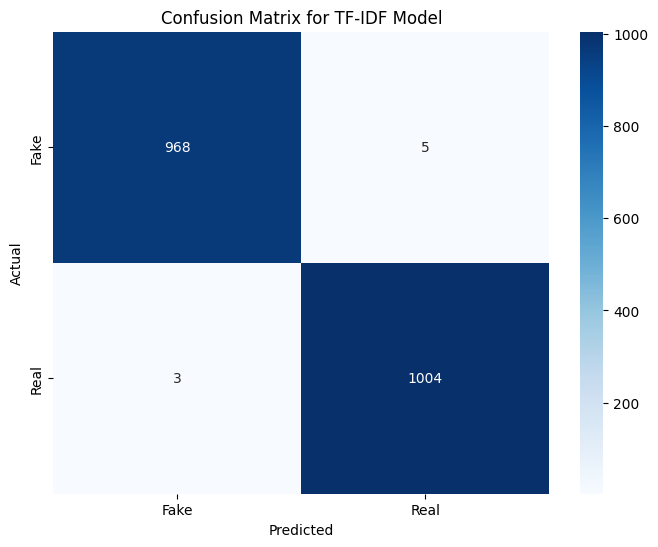

Classification Report for TF-IDF Model:
              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00       973
        Real       1.00      1.00      1.00      1007

    accuracy                           1.00      1980
   macro avg       1.00      1.00      1.00      1980
weighted avg       1.00      1.00      1.00      1980



In [ ]:
# Для TF-IDF модели используем правильные тестовые данные
y_pred = model_tfidf.predict(X_test_tfidf.toarray())
y_pred_classes = y_pred.argmax(axis=-1)
y_true = y_test.argmax(axis=-1)

# Матрица путаницы
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for TF-IDF Model')
plt.show()

# Classification report
print("Classification Report for TF-IDF Model:")
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [ ]:
# Токенизация
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['processed_text'])
X_seq = tokenizer.texts_to_sequences(df['processed_text'])
X_pad = pad_sequences(X_seq, maxlen=100)

In [ ]:
from tensorflow.keras import layers  # Добавляем этот импорт

In [ ]:
# Построение модели с Embedding
embedding_dim = 100
model_embed = Sequential()
model_embed.add(layers.Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
model_embed.add(layers.Flatten())
model_embed.add(Dense(64, activation='relu'))
model_embed.add(Dense(2, activation='softmax'))
model_embed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Flatten

In [ ]:
def build_model_embedding(vocab_size=5000, embedding_dim=100, max_length=100):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                 output_dim=embedding_dim,
                 input_length=max_length),
        GlobalAveragePooling1D(),  # Лучше чем Flatten для текстов
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
# Токенизация текста (добавьте перед этим)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['processed_text'])
X_seq = tokenizer.texts_to_sequences(df['processed_text'])
X_pad = pad_sequences(X_seq, maxlen=100)

In [ ]:
# Теперь можно создать и обучить модель
model_embed = build_model_embedding()
history_embed = model_embed.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_pad, y_test)  # Лучше использовать validation_data чем validation_split
)

Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9510 - loss: 0.3283 - val_accuracy: 0.9919 - val_loss: 0.0291
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9961 - loss: 0.0130 - val_accuracy: 0.9955 - val_loss: 0.0125
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 0.9970 - val_loss: 0.0102
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 7.7796e-04 - val_accuracy: 0.9955 - val_loss: 0.0110
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss: 4.3829e-04 - val_accuracy: 0.9960 - val_loss: 0.0108


In [ ]:
# Оценка модели
loss, accuracy = model_embed.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nEmbedding Model Test Accuracy: {accuracy:.4f}")


Embedding Model Test Accuracy: 0.9960
